In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from torch.hub import load_state_dict_from_url
import shutil

In [2]:
train_path_path= f"{os.getcwd()}/data/train/"
print(f"train path {train_path_path}")

train path /home/jupyter-deeplearning/Organize/data/train/


In [3]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])
batch_size=64
num_gpus=4

In [4]:
dataset = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=15),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.1,.1,.1,.1),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
for _ in range (9):
    aug_data = datasets.ImageFolder(
        train_path_path,
        transforms.Compose([
        transforms.RandomRotation(degrees=15),
            
        transforms.RandomResizedCrop(96),
        transforms.ColorJitter(.1,.1,.1,.1),
        transforms.RandomHorizontalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    dataset=torch.utils.data.ConcatDataset([dataset,aug_data])

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=8, pin_memory=True,drop_last=True)

In [7]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth',
    'resnext101_32x16d': 'https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth',
    'resnext101_32x32d': 'https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth',
    'resnext101_32x48d': 'https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth',
}

In [8]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [9]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [10]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = x.view(batch_size//num_gpus,3,96,96)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(batch_size//num_gpus,-1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def _resnext(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [12]:
def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

def resnext101_32x8d_wsl(pretrained: bool = False, progress: bool = True, **kwargs):
    """Constructs a ResNeXt-101 32x8 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnext('resnext101_32x8d', Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def resnext101_32x16d_wsl(pretrained: bool = False, progress: bool = True, **kwargs):
    """Constructs a ResNeXt-101 32x16 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 16
    return _resnext('resnext101_32x16d', Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def resnext101_32x32d_wsl(pretrained: bool = False, progress: bool = True, **kwargs):
    """Constructs a ResNeXt-101 32x32 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 32
    return _resnext('resnext101_32x32d', Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def resnext101_32x48d_wsl(pretrained: bool = False, progress: bool = True, **kwargs):
    """Constructs a ResNeXt-101 32x48 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 48
    return _resnext('resnext101_32x48d', Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)

In [13]:
model = resnext101_32x16d_wsl()
model=nn.DataParallel(model.cuda())
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.0001)

In [14]:
%cd /home/jupyter-deeplearning/res_model

/home/jupyter-deeplearning/res_model


In [15]:
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=500
model_char="1.7"
model_name=""
patience=10
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name="Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/10/31 18:25:40
epoch: 1/500 | trn loss: 2.4765 | val loss: 2.1636 | val accuracy: 18.3333% 

2020/10/31 18:26:09
epoch: 2/500 | trn loss: 1.9769 | val loss: 1.9631 | val accuracy: 26.4583% 

2020/10/31 18:26:38
epoch: 3/500 | trn loss: 1.9060 | val loss: 1.9278 | val accuracy: 26.5625% 

2020/10/31 18:27:07
epoch: 4/500 | trn loss: 1.8884 | val loss: 1.8416 | val accuracy: 32.0833% 

2020/10/31 18:27:36
epoch: 5/500 | trn loss: 1.8212 | val loss: 1.7907 | val accuracy: 30.5208% 

2020/10/31 18:28:05
epoch: 6/500 | trn loss: 1.7472 | val loss: 1.8100 | val accuracy: 32.2917% 

2020/10/31 18:28:35
epoch: 7/500 | trn loss: 1.6926 | val loss: 1.7470 | val accuracy: 34.7917% 

2020/10/31 18:29:04
epoch: 8/500 | trn loss: 1.7107 | val loss: 1.7274 | val accuracy: 36.1458% 

2020/10/31 18:29:33
epoch: 9/500 | trn loss: 1.6776 | val loss: 1.7237 | val accuracy: 38.3333% 

2020/10/31 18:30:02
epoch: 10/500 | trn loss: 1.6956 | val loss: 1.7998 | val accuracy: 33.5417% 

2020/10/31 18:30:31

2020/10/31 19:01:52
epoch: 75/500 | trn loss: 1.0451 | val loss: 1.1600 | val accuracy: 57.8125% 

2020/10/31 19:02:21
epoch: 76/500 | trn loss: 0.9765 | val loss: 1.2372 | val accuracy: 55.5208% 

2020/10/31 19:02:50
epoch: 77/500 | trn loss: 0.9963 | val loss: 1.1824 | val accuracy: 57.3958% 

2020/10/31 19:03:19
epoch: 78/500 | trn loss: 0.9780 | val loss: 1.1847 | val accuracy: 57.1875% 

2020/10/31 19:03:48
epoch: 79/500 | trn loss: 0.9987 | val loss: 1.1851 | val accuracy: 58.1250% 

2020/10/31 19:04:16
epoch: 80/500 | trn loss: 0.9765 | val loss: 1.2357 | val accuracy: 54.0625% 

2020/10/31 19:04:45
epoch: 81/500 | trn loss: 0.9996 | val loss: 1.2252 | val accuracy: 56.2500% 

2020/10/31 19:05:15
epoch: 82/500 | trn loss: 0.9598 | val loss: 1.1509 | val accuracy: 59.0625% 

2020/10/31 19:05:44
epoch: 83/500 | trn loss: 0.9606 | val loss: 1.1448 | val accuracy: 58.5417% 

2020/10/31 19:06:12
epoch: 84/500 | trn loss: 0.9465 | val loss: 1.1566 | val accuracy: 58.0208% 

2020/10/31

2020/10/31 19:40:03
epoch: 154/500 | trn loss: 0.5857 | val loss: 1.0601 | val accuracy: 65.8333% 

2020/10/31 19:40:31
epoch: 155/500 | trn loss: 0.6128 | val loss: 1.0127 | val accuracy: 64.6875% 

2020/10/31 19:41:00
epoch: 156/500 | trn loss: 0.6048 | val loss: 1.0024 | val accuracy: 68.0208% 

2020/10/31 19:41:29
epoch: 157/500 | trn loss: 0.5903 | val loss: 1.0483 | val accuracy: 65.4167% 

2020/10/31 19:41:58
epoch: 158/500 | trn loss: 0.6075 | val loss: 1.0443 | val accuracy: 66.8750% 

2020/10/31 19:42:27
epoch: 159/500 | trn loss: 0.5767 | val loss: 1.0028 | val accuracy: 66.9792% 

2020/10/31 19:42:56
epoch: 160/500 | trn loss: 0.5978 | val loss: 1.0812 | val accuracy: 64.1667% 

2020/10/31 19:43:25
epoch: 161/500 | trn loss: 0.5676 | val loss: 0.9213 | val accuracy: 69.5833% 

Model replaced and saved as  Custom_model_1.7_0.921
2020/10/31 19:43:55
epoch: 162/500 | trn loss: 0.5913 | val loss: 1.0188 | val accuracy: 68.7500% 

2020/10/31 19:44:24
epoch: 163/500 | trn loss: 0

2020/10/31 20:19:03
epoch: 235/500 | trn loss: 0.4163 | val loss: 1.0210 | val accuracy: 68.0208% 

2020/10/31 20:19:31
epoch: 236/500 | trn loss: 0.4205 | val loss: 1.0390 | val accuracy: 68.2292% 

2020/10/31 20:20:00
epoch: 237/500 | trn loss: 0.4065 | val loss: 1.1435 | val accuracy: 67.9167% 

2020/10/31 20:20:30
epoch: 238/500 | trn loss: 0.4254 | val loss: 1.0551 | val accuracy: 67.9167% 

2020/10/31 20:20:58
epoch: 239/500 | trn loss: 0.4230 | val loss: 0.9842 | val accuracy: 70.0000% 

2020/10/31 20:21:27
epoch: 240/500 | trn loss: 0.4325 | val loss: 1.0382 | val accuracy: 66.8750% 

2020/10/31 20:21:56
epoch: 241/500 | trn loss: 0.3725 | val loss: 0.9643 | val accuracy: 69.5833% 

2020/10/31 20:22:25
epoch: 242/500 | trn loss: 0.4027 | val loss: 0.9833 | val accuracy: 69.3750% 

2020/10/31 20:22:54
epoch: 243/500 | trn loss: 0.4139 | val loss: 0.9617 | val accuracy: 70.0000% 

2020/10/31 20:23:23
epoch: 244/500 | trn loss: 0.4080 | val loss: 0.9745 | val accuracy: 69.6875% 



2020/10/31 20:58:31
epoch: 317/500 | trn loss: 0.3470 | val loss: 1.0517 | val accuracy: 68.6458% 

2020/10/31 20:59:00
epoch: 318/500 | trn loss: 0.3674 | val loss: 1.0577 | val accuracy: 66.8750% 

2020/10/31 20:59:29
epoch: 319/500 | trn loss: 0.3694 | val loss: 1.0045 | val accuracy: 69.2708% 

2020/10/31 20:59:57
epoch: 320/500 | trn loss: 0.3503 | val loss: 0.9140 | val accuracy: 72.1875% 

Model replaced and saved as  Custom_model_1.7_0.914
2020/10/31 21:00:28
epoch: 321/500 | trn loss: 0.3616 | val loss: 0.9836 | val accuracy: 70.9375% 

2020/10/31 21:00:57
epoch: 322/500 | trn loss: 0.3618 | val loss: 1.0797 | val accuracy: 67.3958% 

2020/10/31 21:01:25
epoch: 323/500 | trn loss: 0.3679 | val loss: 0.8587 | val accuracy: 72.8125% 

Model replaced and saved as  Custom_model_1.7_0.859
2020/10/31 21:01:55
epoch: 324/500 | trn loss: 0.3712 | val loss: 0.9326 | val accuracy: 69.8958% 

2020/10/31 21:02:25
epoch: 325/500 | trn loss: 0.3405 | val loss: 1.0524 | val accuracy: 68.8542

2020/10/31 21:37:29
epoch: 398/500 | trn loss: 0.3178 | val loss: 0.9335 | val accuracy: 70.8333% 

2020/10/31 21:37:58
epoch: 399/500 | trn loss: 0.3196 | val loss: 0.9936 | val accuracy: 70.5208% 

2020/10/31 21:38:27
epoch: 400/500 | trn loss: 0.3083 | val loss: 0.9470 | val accuracy: 71.2500% 

2020/10/31 21:38:55
epoch: 401/500 | trn loss: 0.3079 | val loss: 0.9261 | val accuracy: 74.0625% 

2020/10/31 21:39:24
epoch: 402/500 | trn loss: 0.3081 | val loss: 0.9898 | val accuracy: 71.5625% 

2020/10/31 21:39:53
epoch: 403/500 | trn loss: 0.3393 | val loss: 0.9940 | val accuracy: 69.7917% 

2020/10/31 21:40:22
epoch: 404/500 | trn loss: 0.3314 | val loss: 0.9311 | val accuracy: 70.8333% 

2020/10/31 21:40:51
epoch: 405/500 | trn loss: 0.2989 | val loss: 0.9165 | val accuracy: 72.3958% 

2020/10/31 21:41:19
epoch: 406/500 | trn loss: 0.3187 | val loss: 1.0805 | val accuracy: 69.3750% 

2020/10/31 21:41:48
epoch: 407/500 | trn loss: 0.3203 | val loss: 1.0446 | val accuracy: 68.9583% 



2020/10/31 22:16:54
epoch: 480/500 | trn loss: 0.2754 | val loss: 1.0007 | val accuracy: 72.8125% 

2020/10/31 22:17:23
epoch: 481/500 | trn loss: 0.2996 | val loss: 1.0678 | val accuracy: 71.2500% 

2020/10/31 22:17:51
epoch: 482/500 | trn loss: 0.3006 | val loss: 1.0388 | val accuracy: 70.8333% 

2020/10/31 22:18:20
epoch: 483/500 | trn loss: 0.3201 | val loss: 0.9866 | val accuracy: 71.4583% 

2020/10/31 22:18:49
epoch: 484/500 | trn loss: 0.2993 | val loss: 0.9968 | val accuracy: 69.7917% 

2020/10/31 22:19:18
epoch: 485/500 | trn loss: 0.2951 | val loss: 0.9584 | val accuracy: 71.4583% 

2020/10/31 22:19:47
epoch: 486/500 | trn loss: 0.2976 | val loss: 0.9768 | val accuracy: 72.2917% 

2020/10/31 22:20:16
epoch: 487/500 | trn loss: 0.2890 | val loss: 1.0151 | val accuracy: 71.1458% 

2020/10/31 22:20:44
epoch: 488/500 | trn loss: 0.2797 | val loss: 0.9948 | val accuracy: 68.5417% 

2020/10/31 22:21:13
epoch: 489/500 | trn loss: 0.3211 | val loss: 0.8950 | val accuracy: 72.8125% 



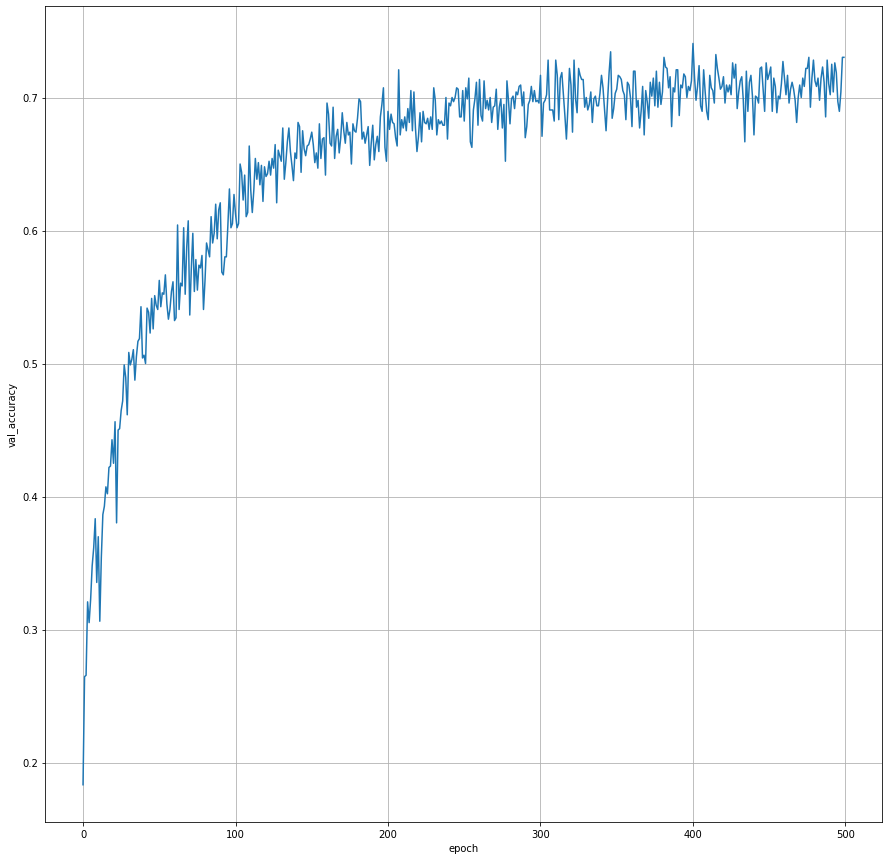

In [16]:
plt.figure(figsize=(15,15))
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.plot(val_acc_list)
plt.grid()

In [18]:
val_acc_list=np.array(val_acc_list)
np.savetxt("ver_1.7.txt", val_acc_list, delimiter=',')

In [19]:
torch.save(model, model_name)